# Библиотеки Python для Data Science: продолжение

# Итоговый проект на тему: "[Credit Default](https://www.kaggle.com/t/fbea09f719f94a9e97e641daeddb39b1)"

> Студент - [Михайлов А.В.](https://geekbrains.ru/users/4305567), Kaggle User Name: avidclam, Display Name: Aleksandr Mikhailov

In [1]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

rc_params = {'figure.figsize': [11, 4.5], 'lines.linewidth': 2.5}

matplotlib.rcParams.update(rc_params) 
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2, rc=rc_params)

In [2]:
from scipy.stats import chi2_contingency, mannwhitneyu

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_precision_recall_curve

In [4]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb

## Импорт данных

In [5]:
TRAIN_DATASET_PATH = './data/credit-default/train.csv'
TEST_DATASET_PATH = './data/credit-default/test.csv'

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
display(df.shape, test_df.shape)

(7500, 17)

(2500, 16)

## Целевые классы

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [7]:
target = 'Credit Default'
FREQ_NAME = 'Chance of Default'  # Обозначение частоты события "1". Ниже встретится сокращение CoD = Chance of Default
target_counts = df[target].value_counts(normalize=True)
target_disbalance = target_counts.loc[0] / target_counts.loc[1]
print(target_counts, target_disbalance, sep='\n****\n')

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64
****
2.5494557501183155


## Вспомогательные функции

In [8]:
# Возвращает частоту единичной целевой переменной для каждого значения категориального признака (пропуски считаются отдельной категорией)
def feature_target_counts(df, features, na_value='NA', target=target, freq_name=FREQ_NAME):
    result_df = df.filter(features + [target]).fillna(na_value).value_counts().unstack(fill_value=0)
    result_df['Count'] = result_df[0] + result_df[1]
    result_df['Share %'] = round(result_df['Count'] * 100 / df.shape[0], 2)
    result_df[freq_name] = result_df[1] / result_df['Count']
    return result_df

In [9]:
# Возврашает частоту единичной целевой переменной для интервала распределения признака (на базе квантилей)
def get_quantile_freq(df, feature, nbins, target=target, freq_name=FREQ_NAME):
    _feature_df = df.filter([feature, target]).dropna()
    quantile_df = pd.DataFrame(_feature_df[feature].quantile(np.linspace(0, 1, nbins+1)))
    quantile_df[feature].iloc[[0, -1]] = np.NINF, np.inf
    quantile_df = quantile_df.reset_index().rename(columns = {'index': 'Quantile'})
    _feature_df['Feature Bin'] = pd.cut(_feature_df[feature], bins = quantile_df[feature], labels=False)
    return feature_target_counts(_feature_df, ['Feature Bin'], target=target, freq_name=freq_name).join(quantile_df)

In [10]:
# Используется для генерации target encoding-признака, сопоставляющего исходному значению признака 
# частоту единичной целевой переменной соответствующего интервала распределения (из функции get_quantile_freq)
def get_feature_freq(df, quantile_freq, na_value=None, freq_name=FREQ_NAME):
    feature = quantile_freq.columns[-1]
    _feature_df = pd.DataFrame({'Feature Bin': pd.cut(df[feature], bins=quantile_freq[feature].tolist() + [np.inf], labels=False)})
    result_df = pd.merge(_feature_df, quantile_freq.reset_index().filter(['Feature Bin', freq_name]), how='left', on='Feature Bin')
    if na_value is not None:
        result_df[freq_name].fillna(na_value, inplace=True)
    return result_df[freq_name].values

## Признаки: анализ существующих, генерация дополнительных

In [11]:
feature_candidates = []  # Здесь будем собирать кандидатов в признаки модели

In [12]:
# Предварительная значимость числовых признаков исходя из корреляции с целевой переменной
target_corr = df.corr()[target].abs().sort_values(ascending=False)[1:]
print(target_corr)

Credit Score                    0.442050
Current Loan Amount             0.226522
Annual Income                   0.101375
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Years of Credit History         0.020567
Number of Credit Problems       0.020088
Current Credit Balance          0.019522
Monthly Debt                    0.018480
Maximum Open Credit             0.014275
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Name: Credit Default, dtype: float64


In [13]:
# Список категориальных признаков:
set(df.columns) - set(target_corr.index) - {target}

{'Home Ownership', 'Purpose', 'Term', 'Years in current job'}

In [14]:
# Признаки с пропущенными значениями
print(df.columns[df.apply(lambda x: x.isnull().any())].sort_values().tolist())

['Annual Income', 'Bankruptcies', 'Credit Score', 'Months since last delinquent', 'Years in current job']


### Credit Score

In [15]:
feature_name = 'Credit Score'
df[feature_name].isnull().value_counts(normalize=True)

False    0.7924
True     0.2076
Name: Credit Score, dtype: float64

In [16]:
# Сразу заметим, что пропущенные значения признака Credit Score совпадают с пропущенными значениями Annual Income
all(df['Credit Score'].isnull() == df['Annual Income'].isnull())

True

**Примечание**: вне данного ноутбука была сделана попытка заполнить пропущенные значения Credit Score и Annual Income через регрессию по другим признакам, но значения R2 в районе ~0.3 показались недостаточными для практического применения этого метода.

In [17]:
# Запомним значение частоты дефолта для данных, у которых пропущен кредитный рейтинг и значения годового дохода, пригодится в дальшейшем.
credit_score_missing_freq = df.loc[df[feature_name].isnull(), target].mean()
credit_score_missing_freq

0.3397559409120103

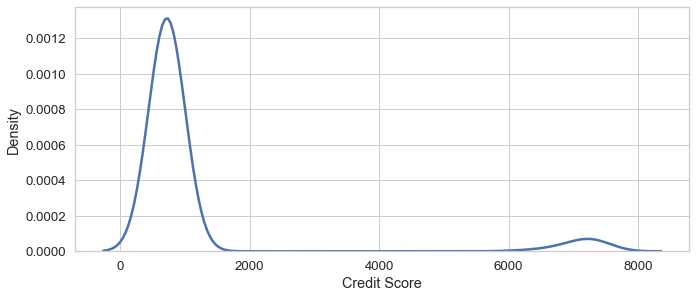

In [18]:
sns.kdeplot(data=df, x=feature_name);

In [19]:
# Выясним, как влияет "расположение на шкале" на целевую переменную
feature_df = df.assign(Tag=np.sign(df[feature_name] - 4000).map({-1: 'Low', 1: 'High'}))
feature_target_counts(feature_df, ['Tag'], 'Missing').sort_values(FREQ_NAME, ascending=False)

Credit Default,0,1,Count,Share %,Chance of Default
Tag,,,,,
High,0,400,400,5.33,1.000000
Missing,1028,529,1557,20.76,0.339756
Low,4359,1184,5543,73.91,0.213603


Как видим, "десятикратные" показатели рейтинга однозначно свидетельствуют о ненадежности клиента.

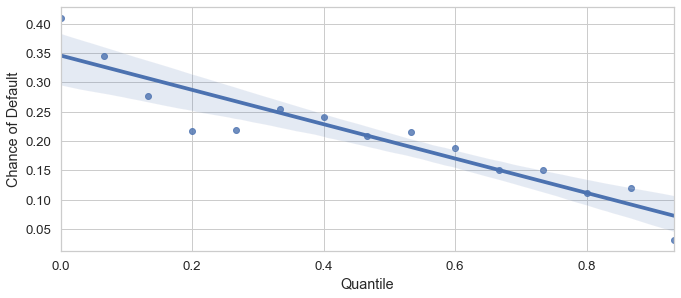

In [20]:
# Посмотрим, как частота дефолта меняется в квантилях распределения "нижней кривой" признака
qfreq_df = get_quantile_freq(df[df[feature_name] < 4000], feature_name, nbins=15)
sns.regplot(data=qfreq_df, x='Quantile', y=FREQ_NAME);

In [21]:
# Создадим признак Credit Score CoD, в котором значению Credit Score сопоставлена частота единичной целевой переменной соответствующего бина (интервала квантилей)
feature_freq_name = f"{feature_name} CoD"
df[feature_freq_name] = get_feature_freq(df, qfreq_df, na_value=credit_score_missing_freq)
test_df[feature_freq_name] = get_feature_freq(test_df, qfreq_df, na_value=credit_score_missing_freq)

In [22]:
# Учтем высокий риск "десятикратных" значений основного признака
df.loc[df[feature_name] > 4000, feature_freq_name] = 1.0
test_df.loc[test_df[feature_name] > 4000, feature_freq_name] = 1.0

In [23]:
df.filter([feature_name, feature_freq_name]).corr()

,Credit Score,Credit Score CoD
Credit Score,1.00000,0.91332
Credit Score CoD,0.91332,1.00000


In [24]:
# Корреляция двух признаков большая, оставим только сгенерированный через целевую переменную
feature_candidates.append(feature_freq_name)

### Annual Income - годовой доход

In [25]:
feature_name = 'Annual Income'
df[feature_name].isnull().value_counts(normalize=True)

False    0.7924
True     0.2076
Name: Annual Income, dtype: float64

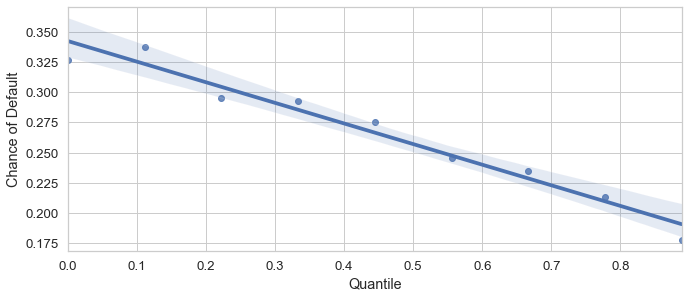

In [26]:
# Создадим признак Annual Income CoD, аналогичный по построению Credit Score CoD
qfreq_df = get_quantile_freq(df, feature_name, nbins=9)
sns.regplot(data=qfreq_df, x='Quantile', y=FREQ_NAME)
feature_freq_name = f"{feature_name} CoD"
df[feature_freq_name] = get_feature_freq(df, qfreq_df, na_value=credit_score_missing_freq)
test_df[feature_freq_name] = get_feature_freq(test_df, qfreq_df, na_value=credit_score_missing_freq)

In [27]:
df.filter([feature_name, feature_freq_name]).corr()

,Annual Income,Annual Income CoD
Annual Income,1.000000,-0.826125
Annual Income CoD,-0.826125,1.000000


In [28]:
feature_candidates.append(feature_freq_name)

### Current Loan Amount - текущая сумма кредита

In [29]:
feature_name = 'Current Loan Amount'

In [30]:
# Есть странное значение 99999999, обозначающее какое-то особое состояние
(df[feature_name] == 99999999).value_counts()

False    6630
True      870
Name: Current Loan Amount, dtype: int64

In [31]:
# Как можно убедиться, "особое состояние" = "уверенность в погашении кредита"
feature_df = df.assign(Tag=df[feature_name] == 99999999)
feature_target_counts(feature_df, ['Tag'])

Credit Default,0,1,Count,Share %,Chance of Default
Tag,,,,,
False,4517,2113,6630,88.4,0.318703
True,870,0,870,11.6,0.000000


In [32]:
# Создадим особый признак
new_feature_name = f"{feature_name} Low Risk"
df[new_feature_name] = (df[feature_name] == 99999999).astype(np.uint8)
test_df[new_feature_name] = (test_df[feature_name] == 99999999).astype(np.uint8)

In [33]:
feature_candidates.append(new_feature_name)  # сам признак используем далее

### Maximum Open Credit - наибольший открытый кредит

Сравнение с Current Loan Amount может быть полезно для разделения целевой переменной.

In [34]:
feature_name = 'Maximum Open Credit'
cross_feature_name = 'Maximum Open Credit - Current Loan Amount'
df[cross_feature_name] = df[feature_name] - df['Current Loan Amount']
test_df[cross_feature_name] = test_df[feature_name] - test_df['Current Loan Amount']

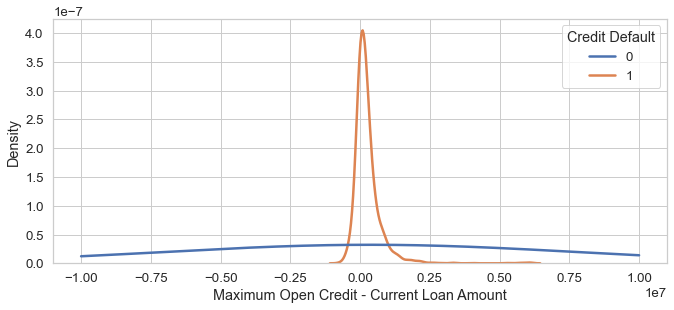

In [35]:
sns.kdeplot(data=df, x=cross_feature_name, hue=target, clip=(-1e7, 1e7));

In [36]:
# Убедимся в отсутствии эквивалентность мат. ожадиний в исследуемых группах, с помощью критерия Манна-Уитни.
mannwhitneyu(
    df.loc[df[target] == 0, cross_feature_name].values,
    df.loc[df[target] == 1, cross_feature_name].values
)

MannwhitneyuResult(statistic=5371067.5, pvalue=7.317532151695133e-05)

In [37]:
df.loc[(df['Current Loan Amount Low Risk'] == 1), cross_feature_name] = df.loc[(df['Current Loan Amount Low Risk'] == 1), 'Maximum Open Credit']
test_df.loc[(test_df['Current Loan Amount Low Risk'] == 1), cross_feature_name] = test_df.loc[(test_df['Current Loan Amount Low Risk'] == 1), 'Maximum Open Credit']

In [38]:
feature_candidates.append(cross_feature_name)

### Current Credit Balance - текущий кредитный баланс и Monthly Debt - ежемесячный долг

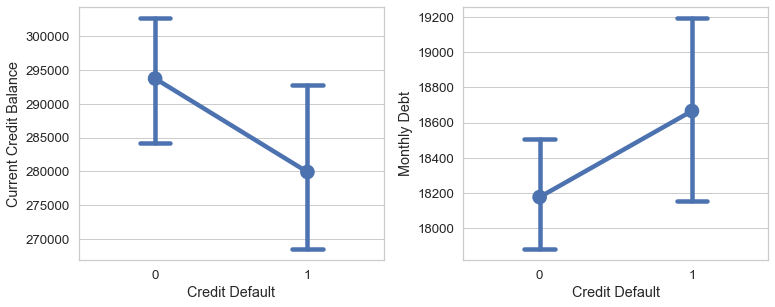

In [39]:
# Оба признака не особенно эффективно разделяют целевую переменную
fig, ax = plt.subplots(1,2)
sns.pointplot(data=df, x=target, y='Current Credit Balance', capsize=.2, ax=ax[0])
sns.pointplot(data=df, x=target, y='Monthly Debt', capsize=.2, ax=ax[1])
fig.tight_layout() 

In [40]:
# Создадим синтетический признак частного от деления 'Current Credit Balance' на 'Monthly Debt'
df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = np.NaN
df['Current Credit Balance/Monthly Debt'] = df['Current Credit Balance'] / df['Monthly Debt']
df['Current Credit Balance/Monthly Debt'].fillna(df['Current Credit Balance/Monthly Debt'].max(), inplace=True)
df['Monthly Debt'].fillna(0, inplace=True)

In [41]:
test_df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = np.NaN
test_df['Current Credit Balance/Monthly Debt'] = test_df['Current Credit Balance'] / test_df['Monthly Debt']
test_df['Current Credit Balance/Monthly Debt'].fillna(test_df['Current Credit Balance/Monthly Debt'].max(), inplace=True)
test_df['Monthly Debt'].fillna(0, inplace=True)

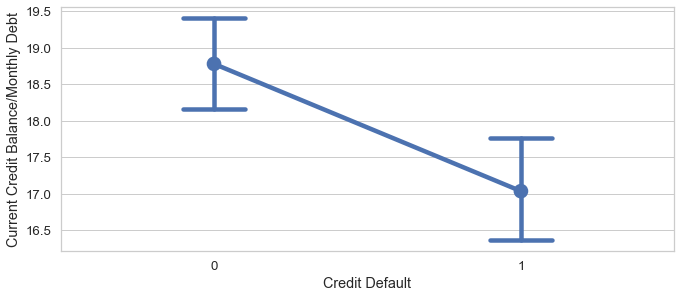

In [42]:
# Ситетический признак разделяет немного лучше
sns.pointplot(data=df, x=target, y='Current Credit Balance/Monthly Debt', capsize=.2);

In [43]:
feature_candidates.append('Current Credit Balance/Monthly Debt')

### Tax Liens - налоговые обременения

In [44]:
feature_name = 'Tax Liens'
agg_df = feature_target_counts(df, [feature_name])
agg_df

Credit Default,0,1,Count,Share %,Chance of Default
Tax Liens,,,,,
0.0,5301,2065,7366,98.21,0.280342
1.0,59,24,83,1.11,0.289157
2.0,15,15,30,0.40,0.500000
3.0,5,5,10,0.13,0.500000
4.0,3,3,6,0.08,0.500000
5.0,1,1,2,0.03,0.500000
6.0,2,0,2,0.03,0.000000
7.0,1,0,1,0.01,0.000000


In [45]:
# Группы мало пригодны для разделения целевой переменной
chi2, p, dof, ex = chi2_contingency(agg_df.loc[[0,1], [0,1]])
p

0.956212700856196

### Number of Credit Problems - количество проблем с кредитом

In [46]:
feature_name = 'Number of Credit Problems'
agg_df = feature_target_counts(df, [feature_name])
agg_df

Credit Default,0,1,Count,Share %,Chance of Default
Number of Credit Problems,,,,,
0.0,4654,1815,6469,86.25,0.280569
1.0,641,241,882,11.76,0.273243
2.0,60,33,93,1.24,0.354839
3.0,21,14,35,0.47,0.400000
4.0,3,6,9,0.12,0.666667
5.0,3,4,7,0.09,0.571429
6.0,4,0,4,0.05,0.000000
7.0,1,0,1,0.01,0.000000


In [47]:
chi2, p, dof, ex = chi2_contingency(agg_df.loc[[0,1], [0,1]])
p

0.6783214582441461

In [48]:
chi2, p, dof, ex = chi2_contingency(agg_df.loc[[0,2], [0,1]])
p

0.14293426550821686

Такая же история, группы либо малочисленные, либо не разделяют целевую переменную в достаточной мере.

### Number of Open Accounts - количество открытых счетов

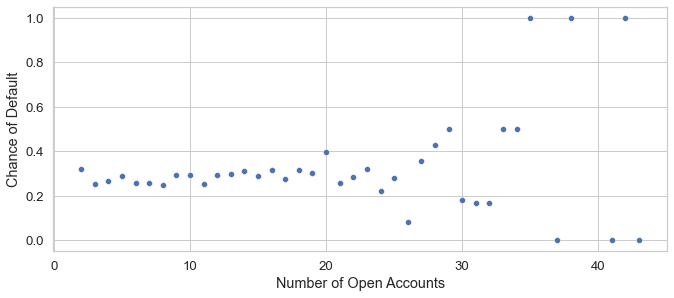

In [49]:
feature_name = 'Number of Open Accounts'
sns.scatterplot(data=feature_target_counts(df, [feature_name]), x=feature_name, y=FREQ_NAME);

In [50]:
# Начиная с некоторого значения признака, в данном случае, с 13, заметно отличие частоты дефолта
agg_df = feature_target_counts(df.assign(Over_12 =(df[feature_name] > 12)), ['Over_12'])
agg_df

Credit Default,0,1,Count,Share %,Chance of Default
Over_12,,,,,
False,3692,1382,5074,67.65,0.272369
True,1695,731,2426,32.35,0.301319


In [51]:
# Убедимся, что частоты не согласованы
chi2, p, dof, ex = chi2_contingency(agg_df.iloc[[0, 1], [0,1]])
p

0.009886126527020072

In [52]:
new_feature_name = f"{feature_name} Over 12"
df[new_feature_name] = (df[feature_name] > 12).astype(np.uint8)
test_df[new_feature_name] = (test_df[feature_name] > 12).astype(np.uint8)

In [53]:
feature_candidates.append(new_feature_name)

### Years in current job - количество лет на текущем месте работы

In [54]:
feature_name = 'Years in current job'
feature_target_counts(df, [feature_name]).sort_values(FREQ_NAME, ascending=False)

Credit Default,0,1,Count,Share %,Chance of Default
Years in current job,,,,,
NA,234,137,371,4.95,0.369272
6 years,302,124,426,5.68,0.291080
< 1 year,404,159,563,7.51,0.282416
1 year,362,142,504,6.72,0.281746
5 years,371,145,516,6.88,0.281008
7 years,285,111,396,5.28,0.280303
4 years,338,131,469,6.25,0.279318
10+ years,1688,644,2332,31.09,0.276158
3 years,450,170,620,8.27,0.274194


In [55]:
# Создадим признак пропущенного значения, а значения самого признака не будем использовать
feature_missing_name = f"{feature_name} Missing"
df[feature_missing_name] = df[feature_name].isnull().astype(np.uint8)
test_df[feature_missing_name] = test_df[feature_name].isnull().astype(np.uint8)

In [56]:
feature_candidates.append(feature_missing_name)

### Years of Credit History - количество лет кредитной истории

In [57]:
feature_name = 'Years of Credit History'

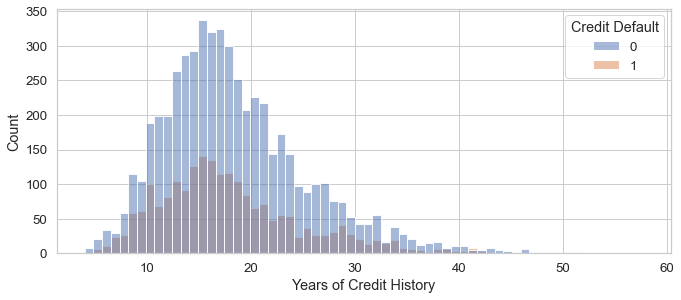

In [58]:
sns.histplot(data=df, x=feature_name, hue=target);

In [59]:
mannwhitneyu(
    df.loc[df[target] == 0, feature_name].values,
    df.loc[df[target] == 1, feature_name].values
)

MannwhitneyuResult(statistic=5461129.5, pvalue=0.003171215731103466)

In [60]:
feature_candidates.append(feature_name)

### Months since last delinquent - количество месяцев с последней просрочки платежа

In [61]:
feature_name = 'Months since last delinquent'
df[feature_name].isnull().value_counts(normalize=True)

True     0.544133
False    0.455867
Name: Months since last delinquent, dtype: float64

In [62]:
feature_df = df.filter([feature_name, 'Annual Income', target]).copy()
feature_df['Tag'] = 10 * feature_df['Annual Income'].isnull() + feature_df[feature_name].isnull() 
feature_target_counts(feature_df, ['Tag'])

Credit Default,0,1,Count,Share %,Chance of Default
Tag,,,,,
0,2003,733,2736,36.48,0.267909
1,2356,851,3207,42.76,0.265357
10,433,250,683,9.11,0.366032
11,595,279,874,11.65,0.319222


In [63]:
# Отметим несколько большую частоту дефолта в данных, у которых отсутствует значение Annual Income, но ненулевое Months since last delinquent
new_feature_name = f"{feature_name} Special"
df[new_feature_name] = ((10 * df['Annual Income'].isnull() + df[feature_name].isnull() == 10)).astype(np.uint8)
test_df[new_feature_name] = (10 * df['Annual Income'].isnull() + test_df[feature_name].isnull() == 10).astype(np.uint8)

In [64]:
feature_target_counts(df, [new_feature_name])

Credit Default,0,1,Count,Share %,Chance of Default
Months since last delinquent Special,,,,,
0,4954,1863,6817,90.89,0.273287
1,433,250,683,9.11,0.366032


In [65]:
feature_candidates.append(new_feature_name)

### Bankruptcies - банкротства

In [66]:
# Группы не особо помогают разделить целевую переменную
feature_target_counts(df, ['Bankruptcies'], -1)

Credit Default,0,1,Count,Share %,Chance of Default
Bankruptcies,,,,,
-1.0,10,4,14,0.19,0.285714
0.0,4782,1878,6660,88.80,0.281982
1.0,569,217,786,10.48,0.276081
2.0,20,11,31,0.41,0.354839
3.0,5,2,7,0.09,0.285714
4.0,1,1,2,0.03,0.500000


### Purpose / Term / Home Ownership

In [67]:
# Создадим новый признак, принимающий значения частоты дефолта, в зависимости от сочетания значений Purpose, Term и Home Ownership
new_feature_name = 'Purpose/Term/Home Ownership CoD'

In [68]:
agg_df = (
    feature_target_counts(df, ['Purpose', 'Term', 'Home Ownership'])
    .sort_values('Share %', ascending=False)
    .filter(['Share %', FREQ_NAME])
    .reset_index()
    .rename(columns={FREQ_NAME: new_feature_name, 'Share %': f"{new_feature_name} Share"})
)
agg_df.head(7)

Credit Default,Purpose,Term,Home Ownership,Purpose/Term/Home Ownership CoD Share,Purpose/Term/Home Ownership CoD
0,debt consolidation,Short Term,Rent,27.35,0.268649
1,debt consolidation,Short Term,Home Mortgage,26.35,0.188259
2,debt consolidation,Long Term,Home Mortgage,11.84,0.382883
3,debt consolidation,Long Term,Rent,7.16,0.472998
4,debt consolidation,Short Term,Own Home,4.80,0.230556
5,other,Short Term,Rent,3.77,0.265018
6,home improvements,Short Term,Home Mortgage,2.96,0.171171


In [69]:
df = pd.merge(df, agg_df, how='left')
df[new_feature_name].fillna(credit_score_missing_freq, inplace=True)
test_df = pd.merge(test_df, agg_df, how='left')
test_df[new_feature_name].fillna(credit_score_missing_freq, inplace=True)

In [70]:
feature_candidates.append(new_feature_name)

## Базовая модель

### Корреляция признаков-кандидатов с целевой переменной и между собой

In [71]:
df.filter(feature_candidates + [target]).corr()[target].abs().sort_values(ascending=False)[1:]

Credit Score CoD                             0.428685
Purpose/Term/Home Ownership CoD              0.232629
Current Loan Amount Low Risk                 0.226871
Annual Income CoD                            0.119038
Months since last delinquent Special         0.059316
Years in current job Missing                 0.044393
Current Credit Balance/Monthly Debt          0.036132
Number of Open Accounts Over 12              0.030106
Years of Credit History                      0.020567
Maximum Open Credit - Current Loan Amount    0.016367
Name: Credit Default, dtype: float64

In [72]:
feature_corr_matrix = df.filter(feature_candidates).corr().round(2)

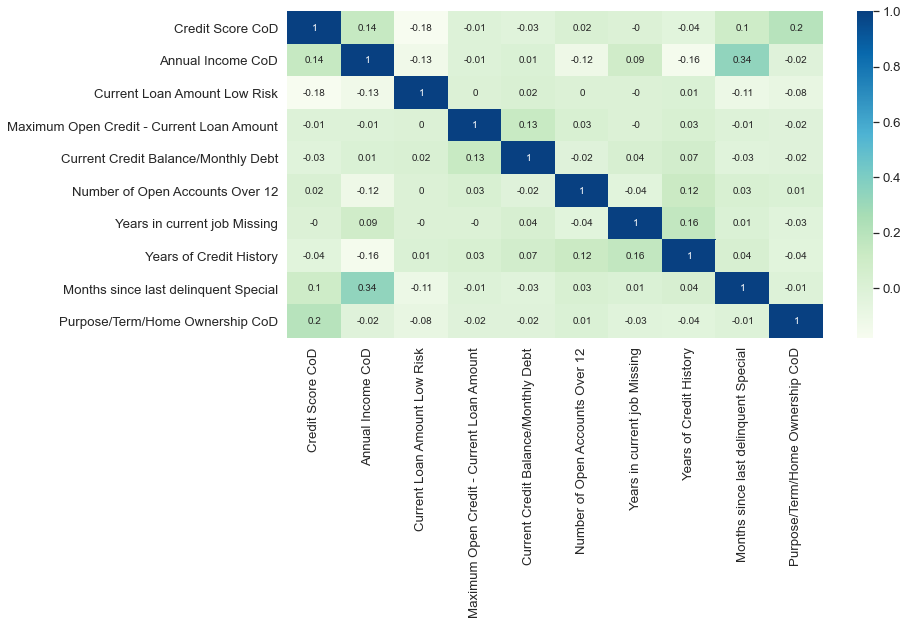

In [73]:
sns_plot = sns.heatmap(feature_corr_matrix, annot=True, cmap='GnBu', annot_kws={"fontsize":10})
sns_plot.figure.set_size_inches((12, 6))

In [74]:
# Считаем, что все кандидаты годятся
use_features = feature_candidates

### Наборы данных для моделей

In [75]:
X = df.filter(use_features)
y = df[target]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=2)
X_train.shape, X_test.shape

((5250, 10), (2250, 10))

In [77]:
basic_model = DecisionTreeClassifier(random_state=2020, max_depth=5)

## Балансировка

Сравним методы Tomeklinks, SMOTE и задание весов классов базовой модели

### Tomeklinks

In [78]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_sample(X_train, y_train)

y_train_balanced.value_counts()

0    3100
1    1479
Name: Credit Default, dtype: int64

In [79]:
basic_model.fit(X_train_balanced, y_train_balanced)
print(classification_report(y_test, basic_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1616
           1       0.81      0.25      0.39       634

    accuracy                           0.77      2250
   macro avg       0.79      0.61      0.62      2250
weighted avg       0.78      0.77      0.73      2250



### SMOTE

In [80]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_sample(X_train, y_train)

y_train_balanced.value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

In [81]:
basic_model.fit(X_train_balanced, y_train_balanced)
print(classification_report(y_test, basic_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1616
           1       0.46      0.59      0.52       634

    accuracy                           0.69      2250
   macro avg       0.64      0.66      0.65      2250
weighted avg       0.72      0.69      0.70      2250



### Задание весов классов

In [82]:
basic_model = DecisionTreeClassifier(random_state=2020, max_depth=5, class_weight={0:1, 1:target_disbalance})
basic_model.fit(X_train, y_train)
pred_train = basic_model.predict(X_train)
pred_test = basic_model.predict(X_test)
print(f'Accuracy на трейне {accuracy_score(y_train, pred_train)}')
print(f'Accuracy на тесте {accuracy_score(y_test, pred_test)}')
print(classification_report(y_train, basic_model.predict(X_train)))
print(classification_report(y_test, basic_model.predict(X_test)))

Accuracy на трейне 0.7346666666666667
Accuracy на тесте 0.7368888888888889
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3771
           1       0.53      0.54      0.53      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.68      0.67      5250
weighted avg       0.74      0.73      0.74      5250

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.53      0.53      0.53       634

    accuracy                           0.74      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250



> Далее будем использовать веса классов

In [83]:
basic_model.fit(X, y)
basic_df = pd.DataFrame({'Id': test_df.index.values, target: basic_model.predict(test_df.filter(use_features))})
basic_df.to_csv('avidclam_submit_basic.csv', index=False)

**Kaggle Score = 0.48945**

## Модели бустинга

Сразу зададим "улучшенные" параметры

### XGBoost

In [84]:
%%time
model_xgb = xgb.XGBClassifier(
    booster='gbtree',
    tree_method='hist',
    importance_type='total_gain',
    random_state=2020,
    scale_pos_weight=target_disbalance,    
    learning_rate=0.07,
    max_depth=5,
    n_estimators=100,
    reg_lambda=30
)
model_xgb.fit(X_train, y_train)
print(classification_report(y_train, model_xgb.predict(X_train)))
print(classification_report(y_test, model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      3771
           1       0.53      0.71      0.60      1479

    accuracy                           0.74      5250
   macro avg       0.70      0.73      0.70      5250
weighted avg       0.77      0.74      0.75      5250

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.49      0.64      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

Wall time: 229 ms


### LightGBM

In [85]:
%%time
model_lgbm = lgbm.LGBMClassifier(
    random_state=2020,
    class_weight={0:1, 1:target_disbalance},
    learning_rate=0.07,
    max_depth=5,
    n_estimators=100,
    reg_lambda=30,
    num_leaves=30
)
model_lgbm.fit(X_train, y_train)
print(classification_report(y_train, model_lgbm.predict(X_train)))
print(classification_report(y_test, model_lgbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      3771
           1       0.52      0.70      0.60      1479

    accuracy                           0.73      5250
   macro avg       0.69      0.73      0.70      5250
weighted avg       0.77      0.73      0.74      5250

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      1616
           1       0.49      0.64      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

Wall time: 201 ms


### CatBoost

In [86]:
%%time
frozen_params = {     
    'silent':True,
    'random_state':2020,
    'eval_metric':'F1',
    'l2_leaf_reg': 50,
    'class_weights': [1, target_disbalance],
    'iterations': 100,
    'max_depth': 5
}
model_cb = catb.CatBoostClassifier(**frozen_params)
model_cb.fit(X_train, y_train)
print(classification_report(y_train, model_cb.predict(X_train)))
print(classification_report(y_test, model_cb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      3771
           1       0.48      0.66      0.56      1479

    accuracy                           0.71      5250
   macro avg       0.66      0.69      0.67      5250
weighted avg       0.74      0.71      0.72      5250

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1616
           1       0.47      0.63      0.54       634

    accuracy                           0.69      2250
   macro avg       0.65      0.68      0.65      2250
weighted avg       0.73      0.69      0.71      2250

Wall time: 470 ms


## Подбор гиперпараметров

Ни одна из моделей радикально не опередила другие по метрикам, для подбора гиперпараметров возьмем LightGBM, так как она имеет преимущество в скорости.

Метрики на тесте:

## Финальная модель и экспорт данных

В финальной модели немного скорректированы параметры для снижения переобучения и повышения Precision (балансом Precision/Recall можно управлять, меняя class_weight).

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      3771
           1       0.56      0.68      0.62      1479

    accuracy                           0.76      5250
   macro avg       0.71      0.74      0.72      5250
weighted avg       0.78      0.76      0.77      5250

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1616
           1       0.50      0.59      0.55       634

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.74      0.72      0.73      2250



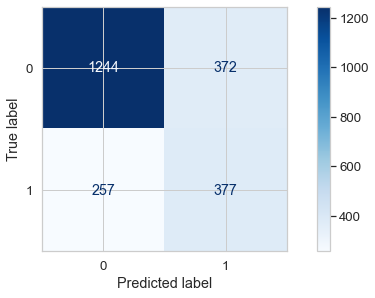

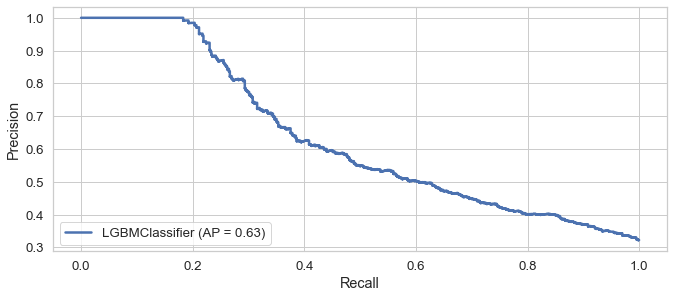

In [87]:
final_params = {'class_weight': {0: 1, 1: target_disbalance*.92},
                'learning_rate': 0.07,
                'max_depth': 5,
                'n_estimators': 200,
                'num_leaves': 20,
                'reg_lambda': 50}
final_model = lgbm.LGBMClassifier(random_state=2020, **final_params)
final_model.fit(X_train, y_train)
print(classification_report(y_train, final_model.predict(X_train)))
print(classification_report(y_test, final_model.predict(X_test)))
plot_confusion_matrix(final_model, X_test, y_test, cmap=plt.cm.Blues)
plot_precision_recall_curve(final_model, X_test, y_test);

In [88]:
final_model.fit(X, y)
final_df = pd.DataFrame({'Id': test_df.index.values, target: final_model.predict(test_df.filter(use_features))})
final_df.to_csv('avidclam_submit.csv', index=False)

**Kaggle Score: 0.54244**